# 04 Custom Data Set Class

In [34]:
import requests
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import os
import pandas as pd
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from torchmetrics import Accuracy, ConfusionMatrix
import mlxtend
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix
import random
import zipfile
from PIL import Image


In [31]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [22]:
# !pip install tqdm 
# !nvcc --version
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# import torch
# torch.__version__


'2.3.0'

In [8]:
# set up gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42
device

'cuda'

In [ ]:
# get data
# assert int(torch.__version__.split('.')[1]) >=11
# assert int(torchvision._version__.split('.')[1]) >= 11
# data_dir = pathlib.Path("../data")

# !nvidia-smi

In [18]:
# int(torch.__version__.split('.')[1])
# int(torchvision._version__.split('.')[1])
# Setup data directory

import pathlib
data_path = Path("data/")
data_dir = pathlib.Path("../data")
image_path = data_path/"pizza steak sushi"
if image_path.is_dir():
    print (f'{image_path} directory already exists.. skipping download')
else:
    print (f'{image_path} does not exisit creting one..')
    image_path.mkdir(parents = True, exist_ok = True)

#
with zipfile.ZipFile(data_dir /'pizza_steak_sushi.zip', 'r') as zip_ref:
    print ('Unzipping pizz, steak  and sushi')
    zip_ref.extractall(image_path)
    
test_path = data_dir /'pizza_steak_sushi.zip'
test_path

data\pizza steak sushi directory already exists.. skipping download
Unzipping pizz, steak  and sushi


WindowsPath('../data/pizza_steak_sushi.zip')

## explore function


In [27]:
# explore directoy
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk (dir_path):
        print (f'end=There are {len(dirnames)} and directories {len (filenames)} images in {dirpath}.')

data_dir = pathlib.Path("../data")
image_path = data_path /"pizza steak sushi"
walk_through_dir(image_path)

end=There are 2 and directories 0 images in data\pizza steak sushi.
end=There are 3 and directories 0 images in data\pizza steak sushi\test.
end=There are 0 and directories 25 images in data\pizza steak sushi\test\pizza.
end=There are 0 and directories 19 images in data\pizza steak sushi\test\steak.
end=There are 0 and directories 31 images in data\pizza steak sushi\test\sushi.
end=There are 3 and directories 0 images in data\pizza steak sushi\train.
end=There are 0 and directories 78 images in data\pizza steak sushi\train\pizza.
end=There are 0 and directories 75 images in data\pizza steak sushi\train\steak.
end=There are 0 and directories 72 images in data\pizza steak sushi\train\sushi.


In [29]:
# set up train test path
train_dir = image_path /'train'
test_dir = image_path/'test'

train_dir, test_dir

(WindowsPath('data/pizza steak sushi/train'),
 WindowsPath('data/pizza steak sushi/test'))

Image height: 408
Image width: 512


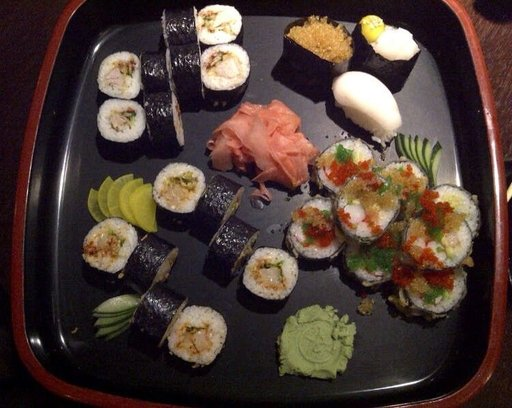

In [39]:
# explore data
random.seed(42)
image_path_list = list (image_path.glob ('*/*/*.jpg'))
image_path_list 
random_image_path = random.choice (image_path_list)
random_image_path
image_class = random_image_path.parent.stem
image_class
img = Image.open(random_image_path)
print (f'Image height: {img.height}')
print (f'Image width: {img.width}')
img

## Code to show set of pictures

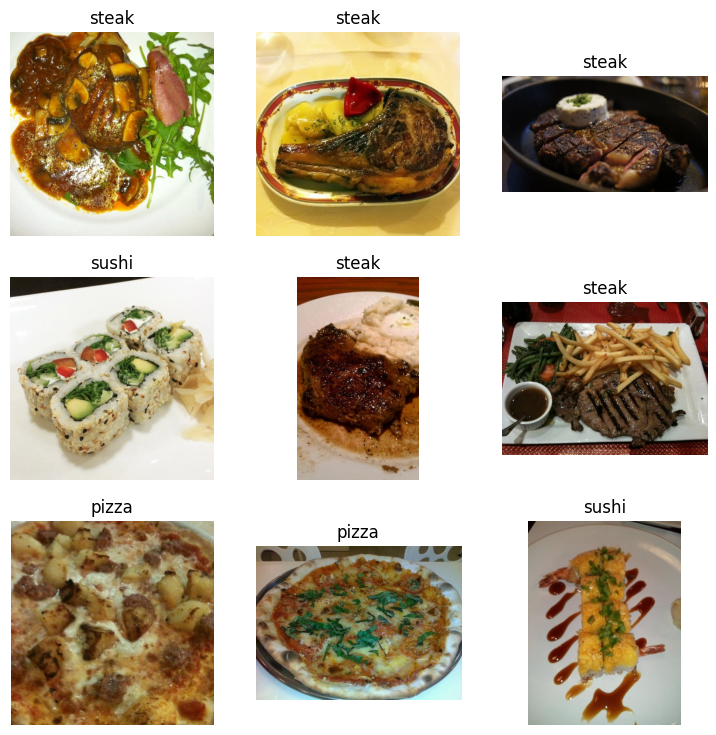

In [42]:
# show list of images
rows, cols = 3, 3
img_rng = range(1, rows * cols +1)
fig  = plt.figure(figsize = (9,9))
for i in img_rng:
    random.seed()
    img_path = random.choice (image_path_list)
    image_class = img_path.parent.stem
    img = Image.open(img_path)
    fig.add_subplot(rows, cols, i)
    plt.imshow (img)
    plt.title (image_class)
    plt.axis(False)
    
    
    
    



In [10]:
# get training data
train_data = datasets.Food101(root=data_dir,
                              split='train',
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split='test',
                             download=True)